## Calculation of Value at Risk using Multi-Asset Black-Scholes Model in Finmc
This notebook uses the model `finmc.models.multi.BSMC` and shows how to
- create dataset for this model
- 

In [14]:
import numpy as np
from finmc.models.multi import BSMC
np.set_printoptions(threshold=1000)

Create dataset for this model. See [Multi-Asset BS Model Documentation](https://finlib.github.io/finmc/models/bsm/) for explanation of model parameters.

In [15]:

# VaR Calculation Function
def calculate_var(simulated_spots, num_shares, portfolio_value, confidence_interval=0.95):
    """
    Calculate VaR for a portfolio based on simulated spot prices.

    Parameters:
    - simulated_spots: N x M array of simulated spot prices, for N paths and M assets
    - num_shares: Number of shares for each asset in the portfolio
    - portfolio_value: Initial portfolio value
    - confidence_interval: Confidence interval for VaR (default 95%)

    Returns:
    - Absolute VaR value
    """
    # Get portoflio value of each path from simulated spot prices and number of shares
    simulated_portfolio_values = np.matmul(simulated_spots, num_shares)

    # Calculate returns relative to the initial portfolio value
    portfolio_returns = (simulated_portfolio_values - portfolio_value) / portfolio_value

    # Sort returns to rank them
    sorted_returns = np.sort(portfolio_returns)

    # Confidence interval and alpha
    alpha = 1 - confidence_interval

    # Calculate rank position
    num_data = len(sorted_returns)
    rank_position = int(np.ceil(alpha * num_data))  # Round up to ensure conservative estimate

    # Extract VaR return using the rank position
    VaR_return = sorted_returns[rank_position - 1]  # Subtract 1 because arrays are 0-indexed

    # Absolute VaR
    VaR = portfolio_value * VaR_return

    return -VaR  # VaR is reported as a positive loss value

# Covariance parameters
v1 = 0.3
v2 = 0.2
rho_values = [-0.9, -0.5, 0.0, 0.5, 0.9]  # Correlation values

# Dataset for BSMC model
dataset = {
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 10,
        "SEED": 1,
    },
    "BASE": "USD",
    "ASSETS": {
        "USD": ("ZERO_RATES", np.array([[2.0, 0.05]])),
        "NVDA": ("FORWARD", np.array([[0.0, 116.00], [2.0, 120.64]])),
        "INTC": ("FORWARD", np.array([[0.0, 21.84], [2.0, 22.70]])),
    },
    "BSM": {
        "ASSETS": ["NVDA", "INTC"],
        "COV": np.array(  # Default covariance matrix with rho = 0
            [
                [v1 * v1, 0.0],
                [0.0, v2 * v2],
            ]
        ),
    },
}

# Initialize the model
model = BSMC(dataset)

# Portfolio value
portfolio_value = 1_000_000
var_values = []

# Iterate over rho values and calculate VaR
for rho in rho_values:
    # Update covariance matrix
    dataset["BSM"]["COV"] = np.array(
        [
            [v1 * v1, rho * v1 * v2],
            [rho * v1 * v2, v2 * v2],
        ]
    )

    # Reset and advance the model
    model.reset()
    model.advance(0.004)

    # Get simulated spot prices into an N X M array, where N is the number of paths and M is the number of assets
    simulated_spots = np.stack([
        model.get_value("NVDA"),
        model.get_value("INTC")
    ], axis=1)

    original_spots = np.array([116.00, 21.84])
    asset_wts = np.array([0.5, 0.5])
    num_shares = portfolio_value * asset_wts / original_spots  # number of shares for each asset

    # Calculate VaR
    var = calculate_var(simulated_spots, num_shares, portfolio_value)
    print(f"VaR at 95% confidence level for rho={rho}: ${var:,.2f}")
    var_values.append(var)


VaR at 95% confidence level for rho=-0.9: $7,555.03
VaR at 95% confidence level for rho=-0.5: $13,656.01
VaR at 95% confidence level for rho=0.0: $18,557.92
VaR at 95% confidence level for rho=0.5: $22,479.90
VaR at 95% confidence level for rho=0.9: $25,124.65


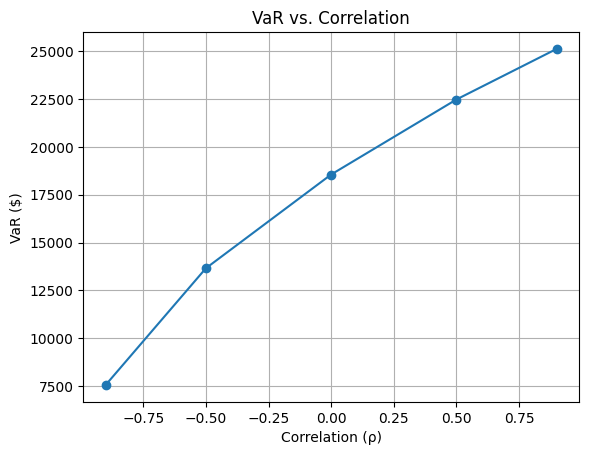

In [16]:
import matplotlib.pyplot as plt

plt.plot(rho_values, var_values, marker="o")
plt.xlabel("Correlation (ρ)")
plt.ylabel("VaR ($)")
plt.title("VaR vs. Correlation")
plt.grid()
plt.show()
